# In the basic_compositing and advanced_compositing notebooks we describe how to produce composites of variables with respect to categorical events.

# In this notebook we show how such composites, or any other spatial field, can be masked, filtered and reduced to a scalar activity index using the IndexGenerator class

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from domino.core import LaggedAnalyser,PatternFilter,IndexGenerator
import cmocean.cm as cm

np.random.seed(5)

example_data_path='./data' #Replace with wherever you have stored the downloaded data files.

## We first compute composites of vertically integrated vapour transport (IVTmag) and zonal mean zonal wind over the Atlantic [80W-40E] on days with extreme North Italian precipitation events:

In [2]:
IVT=xr.open_dataarray(example_data_path+'/IVT.nc').load()


from domino.util import offset_time_dim
UAtl=offset_time_dim(xr.open_dataarray(
    example_data_path+'/Atl_lonmean_U_1979-2021.nc'
    ).load(),-12,'hours')
UAtl=UAtl.sel(lat=IVT.lat)
UAtl=UAtl.assign_coords(plev=UAtl.plev/100)

event=xr.open_dataarray(example_data_path+'/NorthItalian_SON_90Percentile_precip.nc')
analyser=LaggedAnalyser(event=event,variables=dict(IVTmag=IVT,VerticalU=UAtl))
C=analyser.compute_composites(as_anomaly=True)
S=analyser.bootstrap_significance(100,p=0.1)

# If we mask these composites to focus on only gridpoints with significant anomalies we get relatively noisy composites, especially for IVT:

In [3]:
masked_composite=C.where(S==1)

Text(0.5, 1.0, 'Atl zonal wind speed anomaly during event')

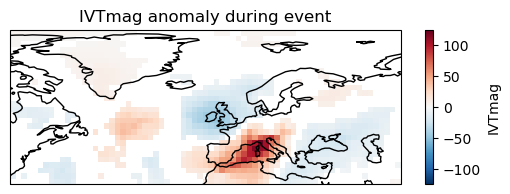

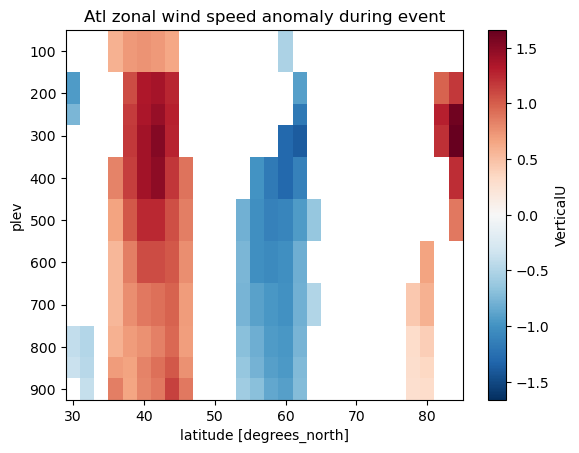

In [4]:
p=masked_composite.IVTmag.sel(lag=0,index_val=1).plot(\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})
p.axes.set_title('IVTmag anomaly during event')
p.axes.coastlines()
p.figure.set_figheight(2)
plt.figure()


p=(masked_composite.VerticalU).sel(index_val=1,lag=0).plot()
p.axes.invert_yaxis()
p.axes.set_title('Atl zonal wind speed anomaly during event')

## We can filter these composites using the PatternFilter class which allows refinement of boolean masks. By passing in 'analyser', PatternFilter will automatically extract the composites and composite significance.

In [5]:
PF=PatternFilter(analyser=analyser)

##Totally equivalent:
#PF=PatternFilter(mask_ds=analyser.composite_sigs,val_ds=analyser.composites)

## PatternFilter refines masks iteratively, applying successive transformations to the underlying boolean mask. The first kind of mask we shall apply is a "value filter" which filters the mask based on whether the composite values meet a certain criteria.

## We shall use the value filter to maintain only IVT gridpoints with an absolute anomaly of at least 30kgm/s and U gridpoints with an absolute anomaly of at least 1m/s.

## By choosing mode='intersection', this filter will be applied in addition to the significance mask we started with.

In [6]:
thresh_dict=dict(IVTmag=30,VerticalU=1)

def abs_amplitude_over_threshold(val_ds,thresh_dict):
    return abs(val_ds)>xr.Dataset(thresh_dict)

PF.apply_value_mask(abs_amplitude_over_threshold,thresh_dict,mode='intersection')
mask1=PF.get_mask() #retrieve the new mask for plotting later.

## We now also apply an "area filter". This is designed to remove small, spatially localised anomalies that consist of less than n connected gridpoints

## First we apply a filter in the lat-lon plane, which will apply only to IVTmag because the U variable has no 'lon' coordinate. We can do this in two ways, either with or without latitude weighting. 

## Firstly we shall, without latitude weighting, maintain unmasked regions that contain at least 30 unmasked gridpoints (120 square degrees on our 2x2 grid)
## Secondly, we shall maintain unmasked regions with an area equivalent to 30 unmasked gridpoints distributed along the equator:


In [7]:
PF.apply_area_mask(30,dims=['lat','lon'],area_type='gridpoint',mode='intersection')
mask2_not_lat_weighted=PF.get_mask()

#We can easily undo a filtering step in this way, as long as we stored the previous mask:
PF.update_mask(mask1,mode='replace')

                    #2x2 grid so times area by 4
PF.apply_area_mask(30*4,dims=['lat','lon'],area_type='spherical',mode='intersection')
mask2_lat_weighted=PF.get_mask()


[4160.84058751]
[3789.64518533  246.86957599   38.65370488   85.67212131]


## Our not area weighted mask simply requires anomalies to consist of 30 connected gridpoints. Our area weighted mask is similar: it is equivalent to requiring anomalies to cover an area equal to a 1deg x 30deg region running along the equator (approximately 4.1e5 km2).

## We can see that the area weighting will remove more high-latitude regions from the mask, as expected:

Text(0.5, 1.0, 'Significant gridpoints >30kgm/s, >4.1e5 km$^2$')

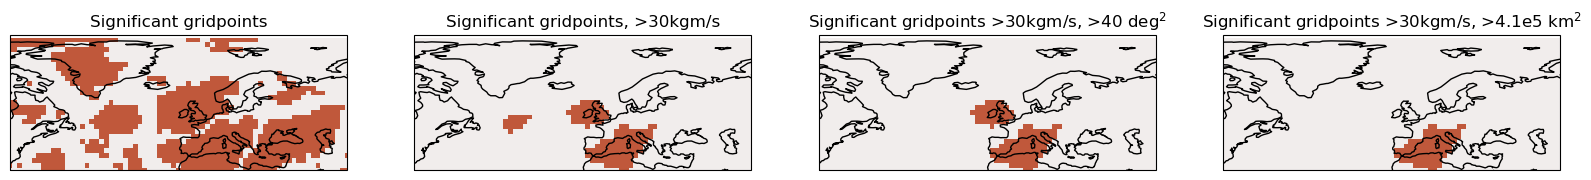

In [9]:
fig,ax=plt.subplots(1,4,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_figwidth(20)
for a in ax.flat:
    a.coastlines()
    a.set_extent([-80,60,30,80])
    
S.IVTmag.sel(lag=0,index_val=1).plot(ax=ax[0],add_colorbar=False,cmap=cm.amp,vmax=2)
mask1.IVTmag.sel(lag=0,index_val=1).plot(ax=ax[1],add_colorbar=False,cmap=cm.amp,vmax=2)
mask2_not_lat_weighted.IVTmag.sel(lag=0,index_val=1).plot(ax=ax[2],add_colorbar=False,cmap=cm.amp,vmax=2)
mask2_lat_weighted.IVTmag.sel(lag=0,index_val=1).plot(ax=ax[3],add_colorbar=False,cmap=cm.amp,vmax=2)

ax[0].set_title('Significant gridpoints')
ax[1].set_title('Significant gridpoints, >30kgm/s')
ax[2].set_title('Significant gridpoints >30kgm/s, >40 deg$^2$')
ax[3].set_title('Significant gridpoints >30kgm/s, >4.1e5 km$^2$')

## Now we apply an area mask to the U variable by specifying the lat-plev plane. In theory we could latitude weight here as well, but our plev coordinate is not evenly spaced and Domino does not currently support latitude weighting in this case.

In [10]:
print(S.plev)

<xarray.DataArray 'plev' (plev: 11)>
array([100., 200., 250., 300., 400., 500., 600., 700., 800., 850., 900.])
Coordinates:
    quantile  float64 0.9
    season    <U3 'SON'
    region    <U11 'North_Italy'
  * plev      (plev) float64 100.0 200.0 250.0 300.0 ... 700.0 800.0 850.0 900.0


In [11]:
PF.apply_area_mask(20,dims=['lat','plev'],area_type='gridpoint',mode='intersection')
mask2=PF.get_mask()

Text(0.5, 1.0, 'Significant gridpoints >1m/s, >20 deg*100hPa')

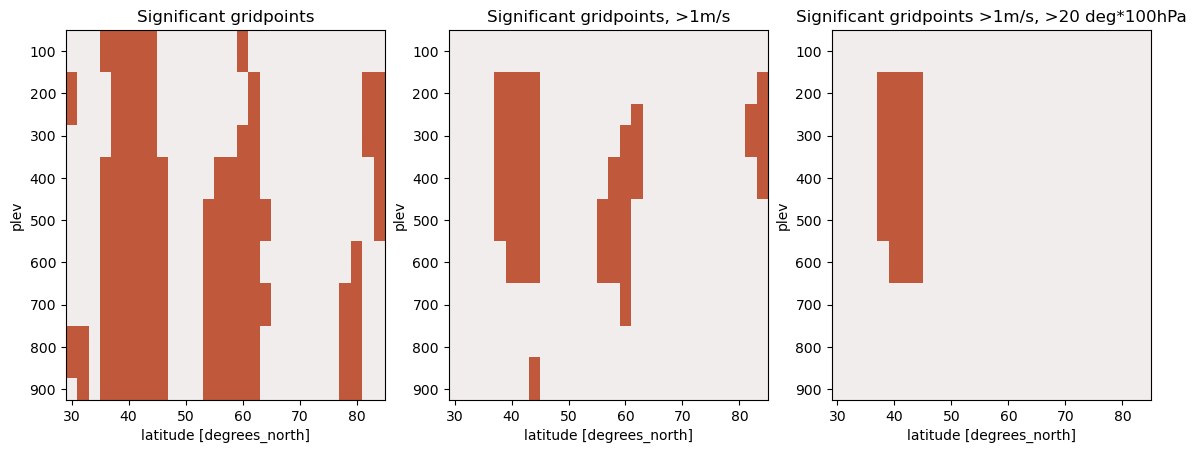

In [12]:
fig,ax=plt.subplots(1,3,)
fig.set_figwidth(14)


S.VerticalU.sel(index_val=1,lag=0).plot(ax=ax[0],cmap=cm.amp,vmax=2,add_colorbar=False)
mask1.VerticalU.sel(index_val=1,lag=0).plot(ax=ax[1],cmap=cm.amp,vmax=2,add_colorbar=False)
mask2.VerticalU.sel(index_val=1,lag=0).plot(ax=ax[2],cmap=cm.amp,vmax=2,add_colorbar=False)

for a in ax:
    a.invert_yaxis()
ax[0].set_title('Significant gridpoints')
ax[1].set_title('Significant gridpoints, >1m/s')
ax[2].set_title('Significant gridpoints >1m/s, >20 deg*100hPa')


# Now we apply our final filter and convolve our mask with an n-point square of True values. This has the effect of smoothing our masks which reduces sampling variability.

In [13]:
PF.apply_convolution(3,['lat','lon'])
PF.apply_convolution(3,['lat','plev'])

In [14]:
mask3=PF.get_mask()

Text(0.5, 1.0, 'Atlantic zon. mean U mask')

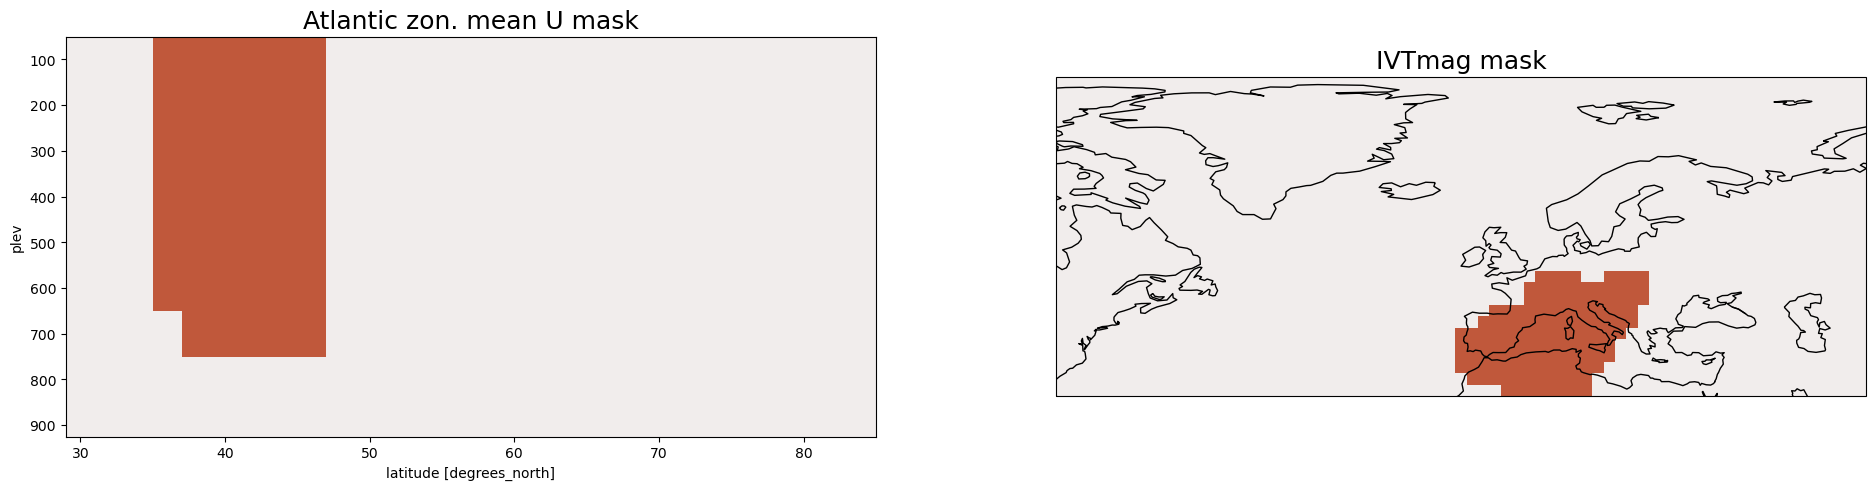

In [15]:
fig=plt.figure()
Uax=fig.add_axes([0,0,0.45,1])
IVTax=fig.add_axes([0.55,0,0.45,1],projection=ccrs.PlateCarree())
fig.set_figwidth(18)
fig.set_figheight(4)

mask3.VerticalU.sel(index_val=1,lag=0).plot(ax=Uax,cmap=cm.amp,vmax=2,add_colorbar=False)
Uax.invert_yaxis()

mask3.IVTmag.sel(index_val=1,lag=0).plot(ax=IVTax,add_colorbar=False,cmap=cm.amp,vmax=2)
IVTax.coastlines()

IVTax.set_title('IVTmag mask',fontsize=18)
Uax.set_title('Atlantic zon. mean U mask',fontsize=18)


# These final masks are much more focused, and we can see that they still pick out the dominant features we saw in our initial composites:

Text(0.5, 1.0, 'Atlantic zon. mean U precursor pattern')

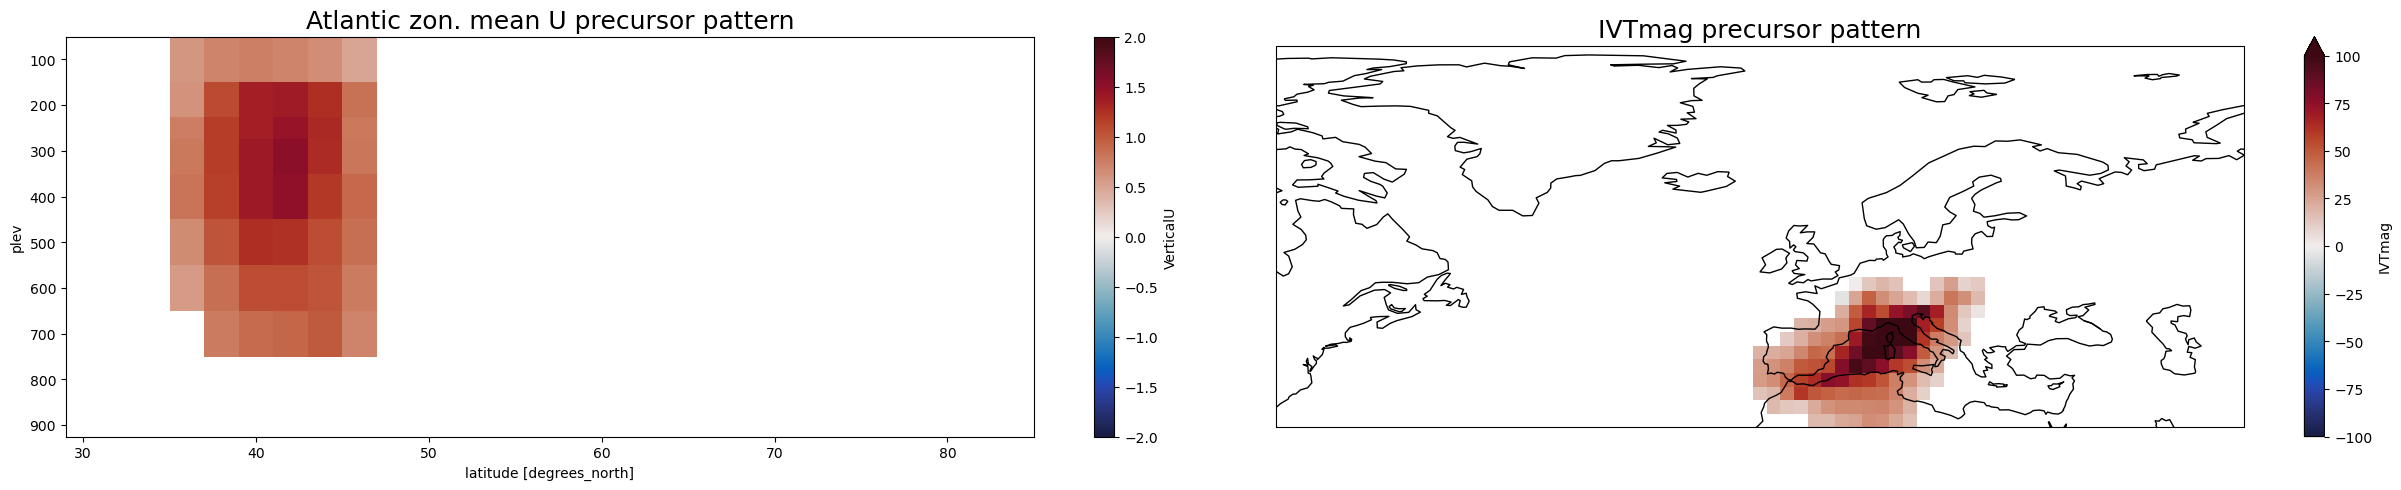

In [16]:
fig=plt.figure()
Uax=fig.add_axes([0,0,0.55,1])
IVTax=fig.add_axes([0.55,0,0.55,1],projection=ccrs.PlateCarree())
fig.set_figwidth(22)
fig.set_figheight(4)
masked_composite=C.where(mask3==1)

masked_composite.VerticalU.sel(index_val=1,lag=0).plot(ax=Uax,cmap=cm.balance,vmin=-2,vmax=2)
Uax.invert_yaxis()

masked_composite.IVTmag.sel(index_val=1,lag=0).plot(ax=IVTax,cmap=cm.balance,vmin=-100,vmax=100)
IVTax.coastlines()

IVTax.set_title('IVTmag precursor pattern',fontsize=18)
Uax.set_title('Atlantic zon. mean U precursor pattern',fontsize=18)

# Happy with our precursor patterns, obtained by applying the mask to the composites, we now can compute our precursor indices. This is handled by the IndexGenerator class:

In [17]:
IG=IndexGenerator()

## IndexGenerator takes our precursor patterns and a dataset of variable data as inputs, and computes dot products between the masked composite and the corresponding variables producing a scalar time series which is then standardised.

## We can easily compute indices for different composites at once, and we specify which composites we wish to project into indices by specifying the slices keyword argument. In this case we want only the lag 0 precursor during positive events (index_val=1) for both variables. We specify this subselection with a dictionary:

In [18]:
index_slices=[dict(index_val=1,lag=0)]


SON_variables=xr.align(analyser.variables,analyser.event)[0]
indices=IG.generate(masked_composite,SON_variables,dim='time',slices=index_slices)

# Our indices dataset now contains two variables, IVTmag_index_val1_lag0 and VerticalU_index_val1_lag0, which corresponds to the combination of variables and slicing parameters we specified

In [19]:
indices.data_vars

Data variables:
    IVTmag_index_val1_lag0     (time) float64 -1.004 -1.341 ... 0.3276 -0.4841
    VerticalU_index_val1_lag0  (time) float32 0.03939 0.1294 ... -0.3563 -1.209

In [20]:
indices.std()

<xarray.Dataset>
Dimensions:                    ()
Coordinates:
    quantile                   float64 0.9
    season                     <U3 'SON'
    region                     <U11 'North_Italy'
    lag                        int64 0
    index_val                  int64 1
Data variables:
    IVTmag_index_val1_lag0     float64 1.0
    VerticalU_index_val1_lag0  float64 1.0

In [21]:
indices.mean()

<xarray.Dataset>
Dimensions:                    ()
Coordinates:
    quantile                   float64 0.9
    season                     <U3 'SON'
    region                     <U11 'North_Italy'
    lag                        int64 0
    index_val                  int64 1
Data variables:
    IVTmag_index_val1_lag0     float64 -1.09e-17
    VerticalU_index_val1_lag0  float32 -3.51e-08

# Here we see some of the time evolution of the indices:

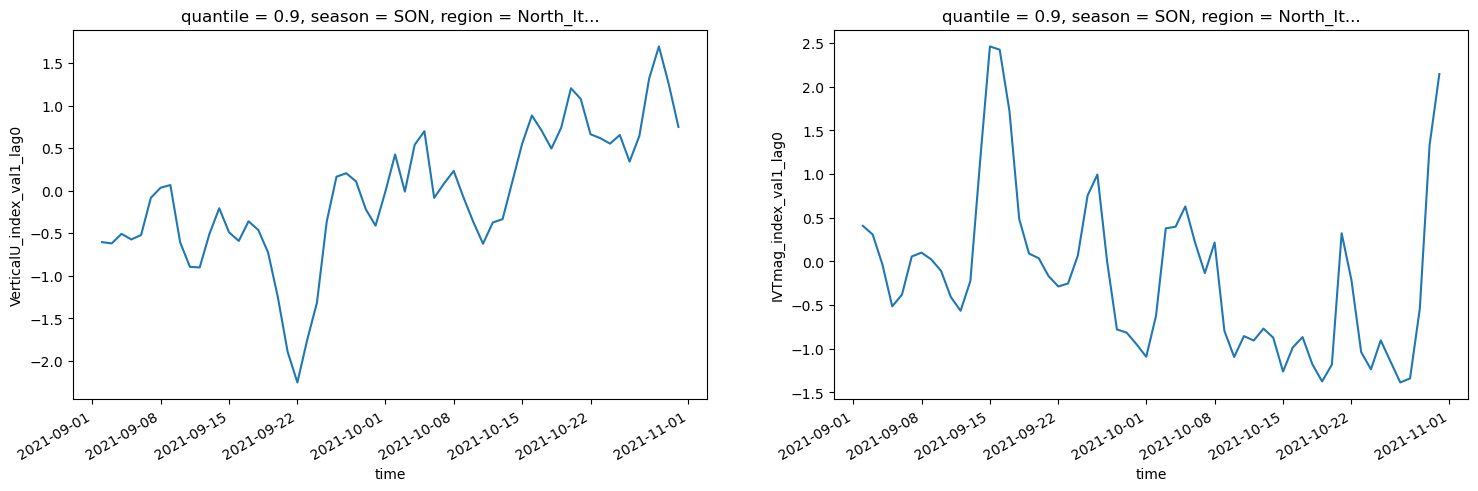

In [22]:
fig,ax=plt.subplots(1,2)

indices.VerticalU_index_val1_lag0[-90:-30].plot(ax=ax[0])
indices.IVTmag_index_val1_lag0[-90:-30].plot(ax=ax[1])
fig.set_figwidth(18)

# Here we show the distribution of index values, during non-events and events. We see the IVTmag index has much more discrimination than the VerticalU index

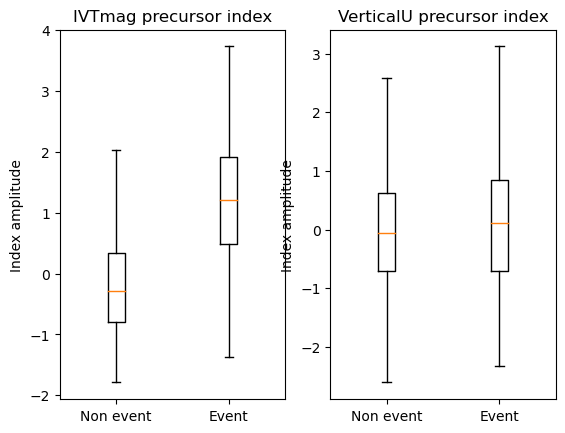

In [27]:
fig,ax=plt.subplots(1,2)

ax[0].boxplot(indices.IVTmag_index_val1_lag0[event==0].values,positions=[0],showfliers=False)
ax[0].boxplot(indices.IVTmag_index_val1_lag0[event==1].values,positions=[1],showfliers=False)
ax[0].set_title('IVTmag precursor index')

ax[1].boxplot(indices.VerticalU_index_val1_lag0[event==0].values,positions=[0],showfliers=False)
ax[1].boxplot(indices.VerticalU_index_val1_lag0[event==1].values,positions=[1],showfliers=False)
ax[1].set_title('VerticalU precursor index')

for a in ax:
    a.set_ylabel('Index amplitude')
    a.set_xticklabels(['Non event', 'Event'])


# We could quantify the skill of these indices more rigorously using Domino's PredictionTest class, but this is left to the 'Index_Predictability' notebook